In [1]:
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
from patsy import bs, dmatrix
import statsmodels.api as sm
from scipy.integrate import quad
from scipy.optimize import *

In [2]:
h = lambda x: (1/pi)*np.arcsin(x**(1/3)) + (1/pi)*np.arcsin(x**(1/6))
f = lambda x: x*np.sin(20*x)

In [3]:
w = np.linspace(0,1,2000)
x = np.linspace(0,1,1000)
y = f(h(x)) + np.random.randn(1000)*0.3
knots1 = np.arange(1, 2) /2 
knots2 = np.arange(1, 16) / 16

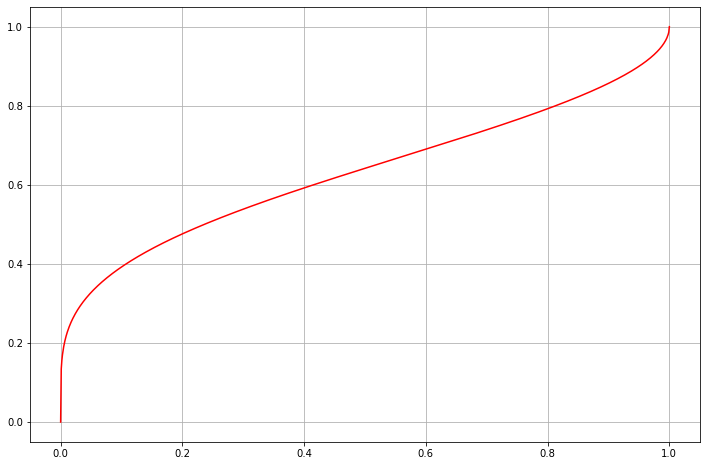

In [4]:
plt.figure(figsize=(12,8))
plt.plot(x, h(x), "r")
plt.grid()
plt.show()

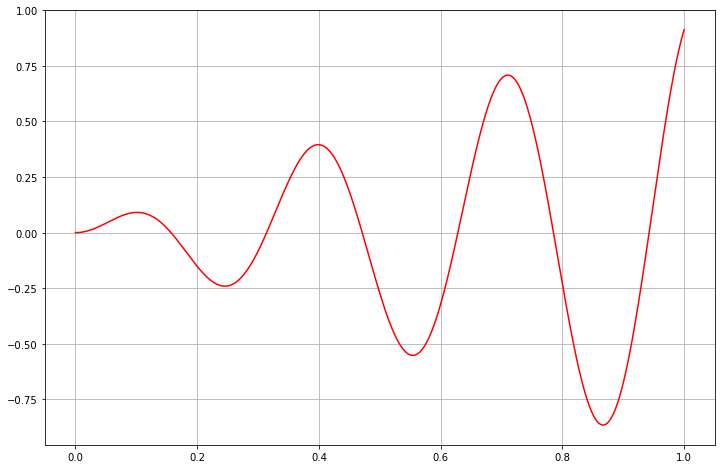

In [5]:
plt.figure(figsize=(12,8))
plt.plot(x, f(x), "r")
plt.grid()
plt.show()

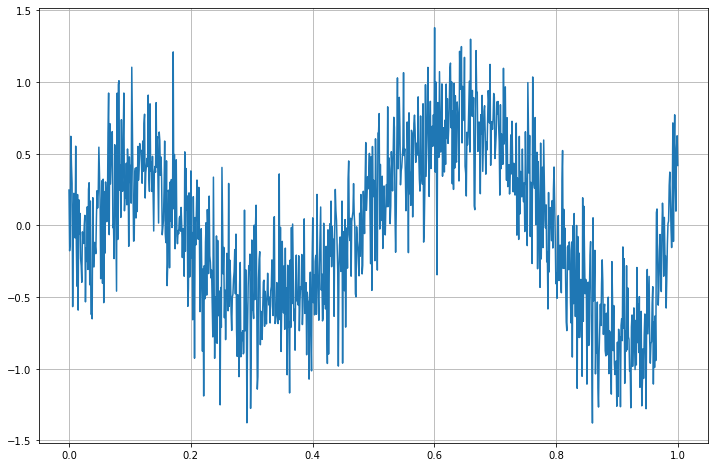

In [6]:
plt.figure(figsize=(12,8))
plt.plot(x, y)
plt.grid()
plt.show()

In [7]:
bx1 = bs(x=x, knots=knots1, lower_bound=0,
         upper_bound=1, include_intercept=True,
         degree=3)
print(bx1.shape)

bx2 = bs(x=x, knots=knots2, lower_bound=0,
         upper_bound=1, include_intercept=True,
         degree=3)
print(bx2.shape)

(1000, 5)
(1000, 19)


In [8]:
mod1 = sm.OLS(h(x), bx1)
res1 = mod1.fit()

mod2 = sm.OLS(h(x), bx2)
res2 = mod2.fit()

In [9]:
print("Sum of squared residuals:", res1.ssr, "\tMSE:", res1.mse_resid) 
# mse_resid = ssr / df_resid
print("Sum of squared residuals:", res2.ssr, "\tMSE:", res2.mse_resid)

Sum of squared residuals: 0.14920609162467535 	MSE: 0.00014995587097957322
Sum of squared residuals: 0.02328613376739242 	MSE: 2.3737139416302162e-05


In [10]:
print("Mean squared error the model:", res1.mse_model) # MSR
print("-----"*20)
print("Mean squared error the model:", res2.mse_model) # MSR

Mean squared error the model: 7.630746866318507
----------------------------------------------------------------------------------------------------
Mean squared error the model: 1.7027170790628507


In [11]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.089e+04
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        16:38:30   Log-Likelihood:                 2986.2
No. Observations:                1000   AIC:                            -5962.
Df Residuals:                     995   BIC:                            -5938.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2340      0.002    126.700      0.000       0.230       0.238
x2             0.5151      0.002    218.158      0.000       0.510       0.520
x3             0.6221      0.003    193.703      0.000       0.616       0.628
x4             0.7976      0.002    337.813      0.000       0.793       0.802
x5             0.9476      0.002    512.971      0.000       0.944       0.951
==============================================================================
Omnibus:                     1470.870   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           849623.307
Skew:                          -8.093   Prob(JB):                         0.00
Kurtosis:                     144.877   Cond. No.                         5.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
print(res1.predict().shape)
print(h(x).shape)

(1000,)
(1000,)


In [13]:
def h_hat(w, knotlist, bx_):
    bw = bs(x=w, knots=knotlist, degree=3,
            lower_bound=0, upper_bound=1,
            include_intercept=True)
    coef = sm.OLS(h(x), bx_).fit().params.reshape((-1, 1))
    ans = bw @ coef
    ans = ans.flatten()
    return ans

def fh_hat(w, knotlist, bx_):
    output = f(h_hat(w, knotlist, bx_))
    return output

In [14]:
estimate1 = fh_hat(w, knots1, bx1)
estimate2 = fh_hat(w, knots2, bx2)
print(estimate1, estimate1.shape)
print(estimate2, estimate2.shape)

[-0.23393221 -0.23486578 -0.23573166 ...  0.07962726  0.08814734
  0.09667541] (2000,)
[0.06204943 0.05358809 0.04423772 ... 0.6936975  0.71436182 0.73471866] (2000,)


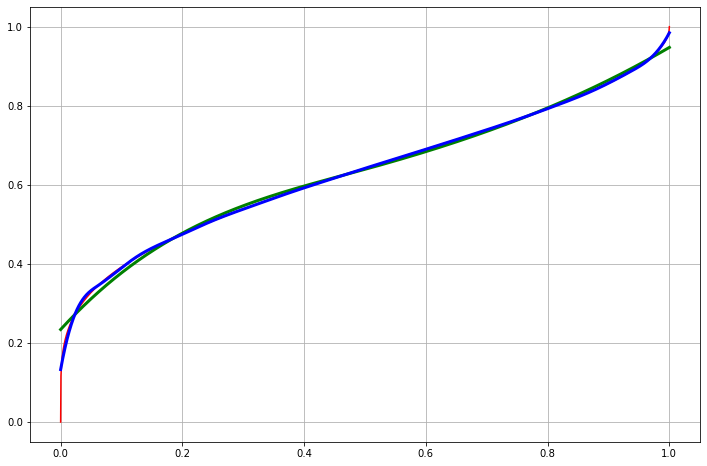

In [15]:
plt.figure(figsize=(12,8))
plt.plot(w, h(w), "r")
plt.plot(w, h_hat(w, knots1, bx1), "g", linewidth=3)
plt.plot(w, h_hat(w, knots2, bx2), "b", linewidth=3)
plt.grid()
plt.show()

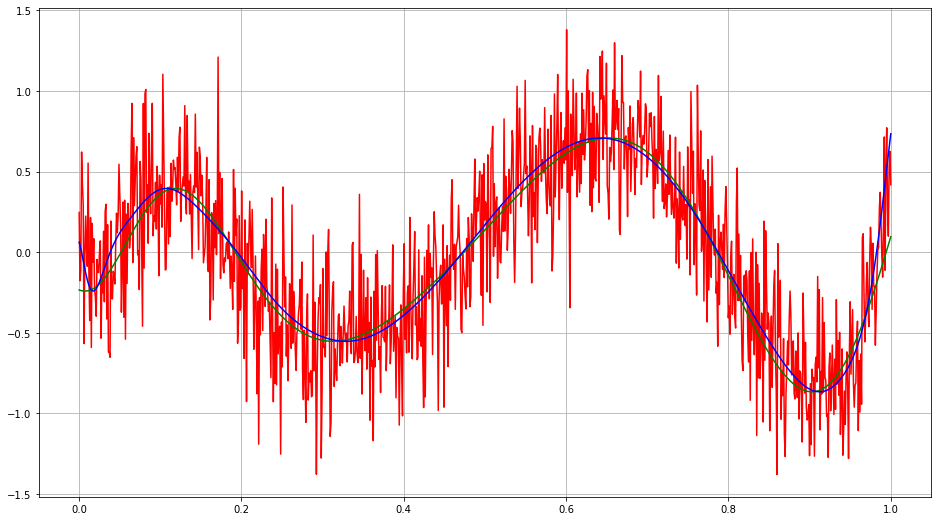

In [16]:
plt.figure(figsize=(16,9))
plt.plot(x, y, "r",
         w, estimate1, "g",
         w, estimate2, "b")
plt.grid()
plt.show()

In [17]:
def ISE1(w):
    return (fh_hat(w, knots1, bx1) - f(h(w)))**2

def ISE2(w):
    return (fh_hat(w, knots2, bx2) - f(h(w)))**2

In [18]:
integral_func1, _ = quad(ISE1, 0,1) 
integral_func2, _ = quad(ISE2, 0,1)
print(integral_func1)
print(integral_func2)

0.00505703248324167
0.00013668943046247042


In [19]:
def find_least_ISE(k):
    ISE_dict = {}
    for i in range(2, k+1):
        knots = np.arange(1, i) /i
        bxk = bs(x=x, knots=knots, lower_bound=0,
                 upper_bound=1, include_intercept=True,
                 degree=3)
        integral_func, _ = quad(lambda x: (fh_hat(x, knots, bxk) - f(h(x)))**2, 0, 1)
        ISE_dict[f"Numbers of knots:{i}"] = integral_func
    
    return ISE_dict
find_least_ISE(10)

{'Numbers of knots:2': 0.00505703248324167,
 'Numbers of knots:3': 0.002162074804188997,
 'Numbers of knots:4': 0.0015643639996119993,
 'Numbers of knots:5': 0.0008373329589837018,
 'Numbers of knots:6': 0.000595838182628904,
 'Numbers of knots:7': 0.0004088593918289818,
 'Numbers of knots:8': 0.0003250817469545799,
 'Numbers of knots:9': 0.00026413349142913957,
 'Numbers of knots:10': 0.0002291571134452103}

In [20]:
def findfind_least_SSE_plots(k):
    knots = np.arange(1, k) / k
    bxk = bs(x=x, knots=knots, lower_bound=0,
                 upper_bound=1, include_intercept=True,
                 degree=3)
    estimate = fh_hat(w, knots, bxk)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    ax1.plot(w, h(w), "r",
             w, h_hat(w, knots, bxk), "b")
    ax1.grid()
    ax2.plot(x, y, "r",
             w, estimate, "b")
    ax2.grid()
    
    plt.show()

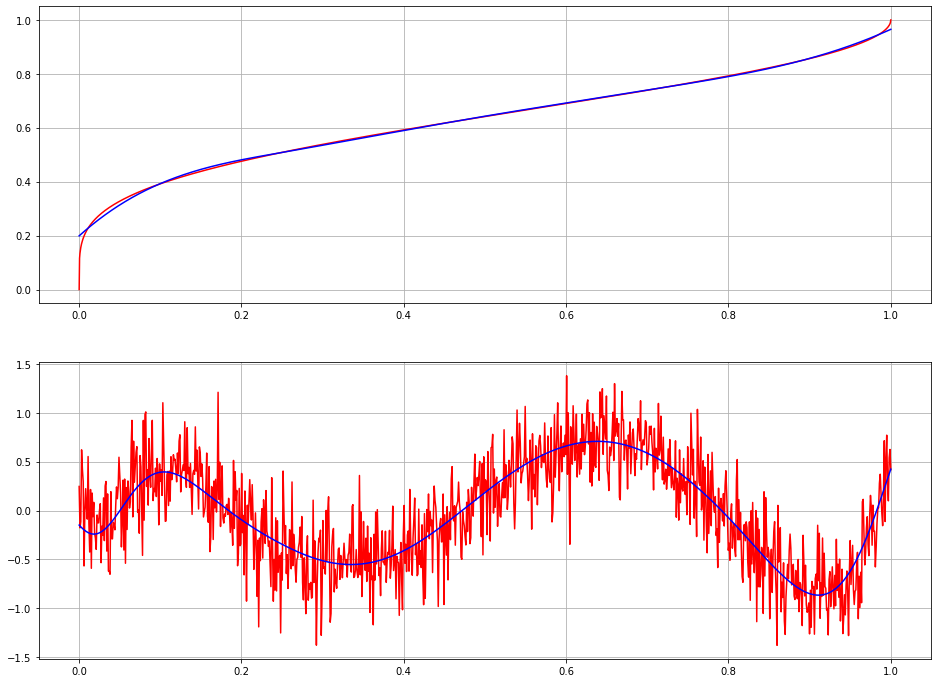

In [21]:
findfind_least_SSE_plots(4)

In [22]:
def find_least_sumsquareerror_of_hhat_under_fixed_knots(theta):
    knots = np.arange(1, 8) / 8
    bxs = bs(x=x, knots=knots, lower_bound=0,
             upper_bound=1, include_intercept=True,
             degree=3)
    
    ans = bxs @ theta.reshape((-1, 1))
    ans = ans.flatten()
    return np.sum((f(h(x)) - f(ans))**2)

In [67]:
bx8 = bs(x=x, knots=np.arange(1, 8) / 8, lower_bound=0,
         upper_bound=1, include_intercept=True,
         degree=3)
mod8 = sm.OLS(h(x), bx8)
res8 = mod8.fit()

In [24]:
find_least_sumsquareerror_of_hhat_under_fixed_knots(res8.params)

0.37559750191716856

In [25]:
opti = minimize(find_least_sumsquareerror_of_h_under_fixed_knots, res8.params,
                method='Nelder-Mead', options={'maxiter':50})
print(opti.fun, "\n", opti.x)

0.30996892381455743 
 [0.1698152  0.35405307 0.41499689 0.51741202 0.58035611 0.64156271
 0.70565367 0.7606164  0.83792386 0.88828247 0.97786092]


In [65]:
opti_value_list = []
for i in range(100, 501, 100):
    
    def find_least_sumsquareerror_of_h_under_fixed_knots(theta):
        knots = np.arange(1, i) / i
        bxs = bs(x=x, knots=knots, lower_bound=0,
                upper_bound=1, include_intercept=True,
                degree=3)
    
        ans = bxs @ theta.reshape((-1, 1))
        # h(x).shape = (1000,)
        ans = ans.flatten()
        return np.sum((f(h(x)) - f(ans))**2)
    
    bxi = bs(x=x, knots=np.arange(1, i) / i, lower_bound=0,
         upper_bound=1, include_intercept=True,
         degree=3)
    modi = sm.OLS(h(x), bxi)
    resi = modi.fit()
    opt = minimize(find_least_sumsquareerror_of_h_under_fixed_knots, resi.params,
                   method='Nelder-Mead', options={'maxiter':50})
    # print(f"\noptimal value {i}:", opt.fun, f"\noptimal vector {i}:", opt.x)
    opti_value_list.append(opt.fun)

In [66]:
print(min(opti_value_list))
print(opti_value_list.index(min(opti_value_list)))
print(opti_value_list)

6.519341976093928e-05
4
[0.01699082140690607, 0.0067497547325832555, 0.0028375881914117712, 0.0007584640246056957, 6.519341976093928e-05]
